In [99]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

In [22]:
data = pd.read_csv('../weather.csv'   )
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,Partly cloudy throughout the day.


In [23]:
data.columns = ['Formatted_Date', 'Summary', 'Precip_Type', 'Temperature',
       'Apparent_Temperature', 'Humidity', 'Win_Speed',
       'Wind_Bearing', 'Visibility', 'Pressure',
       'Daily_Summary']

In [24]:
data.Precip_Type.nunique(),data.Summary.nunique(),data.Daily_Summary.nunique()
# summary variables have more than 5 unique categories. Hence removing them from the model building 

(2, 26, 214)

# EDA 

In [89]:
data.describe()

,Temperature,Apparent_Temperature,Humidity,Win_Speed,Wind_Bearing,Visibility,Pressure
count,77268.000000,77268.000000,77268.000000,77268.000000,77268.000000,77268.000000,77268.000000
mean,11.929638,10.848588,0.734417,10.803935,187.735725,10.350499,1003.216115
std,9.567429,10.720101,0.195432,6.896537,107.330348,4.189660,117.093492
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.555556,2.272222,0.600000,5.828200,117.000000,8.339800,1011.907500
50%,11.988889,11.988889,0.780000,9.965900,180.000000,10.046400,1016.470000
75%,18.844444,18.844444,0.890000,14.135800,290.000000,14.812000,1021.080000
max,39.905556,38.416667,1.000000,63.852600,359.000000,16.100000,1046.380000


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77268 entries, 0 to 77284
Data columns (total 11 columns):
Formatted_Date          77268 non-null object
Summary                 77268 non-null object
Precip_Type             76864 non-null object
Temperature             77268 non-null float64
Apparent_Temperature    77268 non-null float64
Humidity                77268 non-null float64
Win_Speed               77268 non-null float64
Wind_Bearing            77268 non-null int64
Visibility              77268 non-null float64
Pressure                77268 non-null float64
Daily_Summary           77268 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 9.6+ MB


In [91]:
# correlation of variables with target 
data.corr()['Temperature']

Temperature             1.000000
Apparent_Temperature    0.992648
Humidity               -0.631968
Win_Speed               0.006377
Wind_Bearing            0.028694
Visibility              0.393078
Pressure               -0.008353
Name: Temperature, dtype: float64

In [92]:
# is there a correlation among variables excluding target
correlations=data.corr()
attrs = correlations.iloc[:-1,:-1]
attrs

,Temperature,Apparent_Temperature,Humidity,Win_Speed,Wind_Bearing,Visibility
Temperature,1.000000,0.992648,-0.631968,0.006377,0.028694,0.393078
Apparent_Temperature,0.992648,1.000000,-0.602390,-0.059436,0.027572,0.381863
Humidity,-0.631968,-0.602390,1.000000,-0.222299,0.001625,-0.370666
Win_Speed,0.006377,-0.059436,-0.222299,1.000000,0.104332,0.100159
Wind_Bearing,0.028694,0.027572,0.001625,0.104332,1.000000,0.048952
Visibility,0.393078,0.381863,-0.370666,0.100159,0.048952,1.000000


In [93]:
# check for multicollinearity
threshold = 0.5
important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]) \
    .unstack().dropna().to_dict()

unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), 
        columns=['Attribute Pair', 'Correlation'])

    # sorted by absolute value
unique_important_corrs = unique_important_corrs.ix[
    abs(unique_important_corrs['Correlation']).argsort()[::-1]]

unique_important_corrs

C:\Users\sudha\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


,Attribute Pair,Correlation
2,"(Apparent_Temperature, Temperature)",0.992648
0,"(Humidity, Temperature)",-0.631968
1,"(Apparent_Temperature, Humidity)",-0.602390


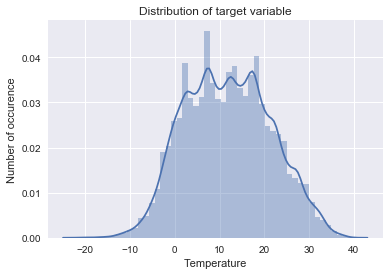

In [100]:
# check impact of x's on y 
sns.distplot(data.Temperature)
plt.title("Distribution of target variable")
plt.ylabel("Number of occurence")
plt.xlabel("Temperature")


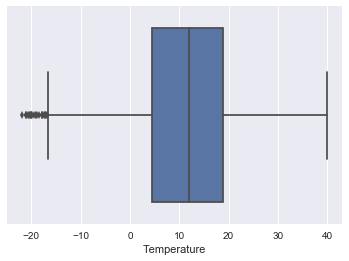

In [101]:
sns.boxplot("Temperature", data = data)

# data preprocessing 

In [25]:
# drop columns that are not required 
# drop duplicates
data.drop_duplicates(keep = 'first', inplace= True )
# drop multicorrelated var
columns_top_drop = ['Formatted_Date', 'Apparent_Temperature' , 'Daily_Summary', 'Summary']
# excluding these columns during selection 
X = data[[ 'Precip_Type','Humidity', 'Win_Speed', 'Wind_Bearing', 'Visibility', 'Pressure']]
y = data['Temperature']


# impute missing values
X['Precip_Type'] = X['Precip_Type'].fillna(X['Precip_Type'].value_counts().index[0])

# scale numeric values

# one hot encoding - exclude categorical variable 

C:\Users\sudha\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


array(['rain', 'snow'], dtype=object)

In [27]:
from sklearn.preprocessing import StandardScaler
num_cols = X.columns[X.dtypes.apply(lambda c: np.issubdtype(c, np.number))]  # df._get_numeric_data().columns
print(num_cols)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

Index([u'Humidity', u'Win_Speed', u'Wind_Bearing', u'Visibility', u'Pressure'], dtype='object')


C:\Users\sudha\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\sudha\Anaconda2\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [39]:
X.head()

,Precip_Type,Humidity,Win_Speed,Wind_Bearing,Visibility,Pressure
0,rain,0.796103,0.480790,0.589439,1.306988,0.101747
1,rain,0.642596,0.501801,0.663976,1.306988,0.106018
2,rain,0.796103,-0.996961,0.151536,1.099476,0.108665
3,rain,0.489089,0.478456,0.757147,1.306988,0.112679
4,rain,0.489089,0.034897,0.663976,1.306988,0.113533


In [47]:
# one hot encoded precip_type var 
X['Precip_Type'] = X['Precip_Type'].apply(lambda x: 1 if x =='rain' else 0 )

C:\Users\sudha\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [48]:
# split data in train and test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X , y ,test_size=0.30, random_state=42 )

In [53]:
def compute_cost(X, y, theta):
    '''
    Compute cost for linear regression
    '''

    m = y.size

    predictions = X.dot(theta)

    sq_errors = (predictions - y)

    current_cost_j = (1.0 / (2 * m)) * sq_errors.T.dot(sq_errors)

    return current_cost_j, np.mean(np.square(sq_errors))


def gradient_descent(X, y, theta, alpha, num_iters):
    '''
    gradient descent to learn theta
    '''
    m = y.size
    cost_past_val = zeros(shape=(num_iters, 1))

    for i in range(num_iters):

        predictions = X.dot(theta)

        theta_size = theta.size

        for n in range(theta_size):
            temp = X[:, n]
            temp.shape = (m, 1)
            errors_x1 = (predictions - y) * temp
            theta[n][0] = theta[n][0] - alpha * (1.0 / m) * errors_x1.sum()

        cost_past_val[i, 0], train_errors = compute_cost(X, y, theta)
    print('train error: ', train_errors)
    return theta, cost_past_val, train_errors


In [54]:
from numpy import zeros
import numpy as np 


#Initialize theta parameters

X = np.c_[np.ones(X.shape[0]),X] 
y = y.reshape(y.shape[0] , 1)
theta = zeros(shape=(X.shape[1], 1))

alpha = 0.0001 #Step size
iterations = 1000#No. of iterations
m = y.size #No. of data points
np.random.seed(42) #Set the seed

slope , cost_history, train_err = gradient_descent(X, y, theta, alpha, iterations)

C:\Users\sudha\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


('train error: ', 199.13446730440387)


# Comparing the performance of different error functions 

In [ ]:
Mean square error, Mean Absolute error, Mean absolute percentage error

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [69]:
def predictions( model , scaler , X_test):
    intercept = slope[0]
    X_test[['Humidity', 'Win_Speed', 'Wind_Bearing','Visibility', 'Pressure']] = scaler.inverse_transform(X_test[['Humidity', 'Win_Speed', 'Wind_Bearing','Visibility', 'Pressure']])
    return np.dot(X_test, slope[1:]) + intercept
pred = predictions(slope , scaler , X_test)
mean_squared_error(y_test , pred)

213.72077214585227

In [72]:
mean_absolute_error(y_test , pred)

12.043029522368583

In [74]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_test , pred)


C:\Users\sudha\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


inf

In [80]:
len(y_test[y_test==0])

69

I found that there are 69 values in target that are equal to Zero This causes the MAPE value to become inf. 
Mape may not be a good metric in this case, as it has a disadvantage when actual values contain zero values
While, MAE treats the error deviations in either directions the same way, 
I observed that the error in MSE punishes large error more because it squares all the errors. Hence, we have larger MSE than MAE 



# Behaviour of regression coefficients 

In [84]:
def run_experiments(X , y,  alpha , iterations , seed = 42):
    
    theta = np.random.rand(X.shape[1], 1)
    slope , cost ,tr_err = gradient_descent(X, y, theta, alpha, iterations)
    return slope, cost

# test 1 
theta1 , costs1  = run_experiments(X , y , 0.001 ,100, seed = 100 )
# test 2 
theta2 , costs2  = run_experiments(X , y , 0.001 ,1000, seed = 200 )
# test 3 
theta3 , costs3  = run_experiments(X , y , 0.001 ,5000, seed = 300 ) 

('train error: ', 186.20194677032538)
('train error: ', 74.64740956709915)
('train error: ', 50.351689875188875)


C:\Users\sudha\Anaconda2\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


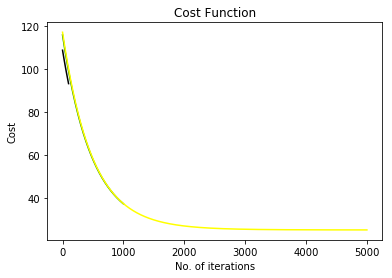

In [85]:
plt.gca().set_color_cycle(['black', 'green' , 'yellow'])

plt.title('Cost Function')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(np.arange(100) ,costs1 ,  label = '500')
plt.plot(np.arange(1000),costs2 ,   label = '1000')
plt.plot(np.arange(5000),costs3 ,   label = '2000')
plt.show()
 

In [86]:
# different learning parameters with fixed regression coefficients
# test 1 
theta1_b , costs1_b  = run_experiments(X , y , 0.01 ,100, seed = 42 )
# test 2 
theta2_b , costs2_b  = run_experiments(X , y , 0.001 ,2000, seed = 42 )
# test 3 
theta3_b , costs3_b  = run_experiments(X , y , 0.0001 ,5000, seed = 42 ) 

('train error: ', 73.59148955930911)
('train error: ', 53.68184866370157)
('train error: ', 116.7420305743412)


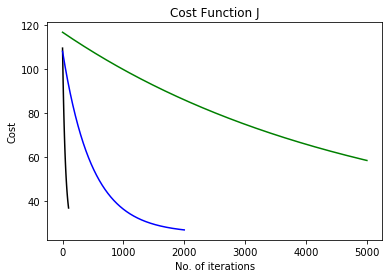

In [87]:
plt.gca().set_color_cycle(['black', 'blue' , 'green'])

plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(np.arange(100) ,costs1_b ,  label = '500')
plt.plot(np.arange(2000),costs2_b ,   label = '1000')
plt.plot(np.arange(5000),costs3_b ,   label = '2000')
plt.show()


In [104]:
#scaler
import pickle

with open('scaler.obj', 'wb') as f:
    pickle.dump(scaler, f)

In [88]:
theta

array([[ 1.13530917],
       [ 0.        ],
       [-0.56901267],
       [-0.002306  ],
       [ 0.02532127],
       [ 0.34745948],
       [-0.00838819]])

In [105]:
num_cols

Index([u'Humidity', u'Win_Speed', u'Wind_Bearing', u'Visibility', u'Pressure'], dtype='object')

In [ ]:
the above cell shows intercept and regression coefficients in an array. 
The maginitude of theta in above cell is a measure of how much does the value impact the target variable
The sign represents the direction in which it impacts the target variable. 
The target variable is impacted by summation of all coefficients in the form of simple line equation. 